In [24]:
#########################################################################################
#                                       0 - VARIABLE SETUP
#########################################################################################

import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import simps
import matplotlib.ticker as ticker 
import pandas as pd
import spm1d

Data_Labels=[['Set_A','Set_A_N','Set_A_W'],
             ['Set_B','Set_B_N','Set_B_W'],
             ['Set_C','Set_C_N','Set_C_W'],
             ['Set_D','Set_D_N','Set_D_W']]

Titles=['RawCurves','Mean & StdDevs','SPM1D']

Colours =[['royalblue','g','r','m','darkorange'],
          ['lightsteelblue','lightgreen','salmon','violet','moccasin']]

Test_Sets = ['Test_Set_1','Test_Set_2','Test_Set_3','Test_Set_4']


Narrow=[0.02,0.01,0,-0.01,-0.02]
Wide = [0.75,0.25,0,-0.25,-0.75]


In [25]:
#########################################################################################
#                                       1 - ORGANIZE DATA
#########################################################################################


x = np.arange(0,4*np.pi,0.1) # start,stop,step

MaxIndex = 4*np.pi


# ********************  MANUALLY INITIALIZE CURVES TO BE COMPARED *******************************
#   Set_? = a * sin(bx + c) + d
#   a = Amplitude, b = Period,  c = Phase Shift, d = Vertical Shift
#
Set_A = np.sin(x)               
Set_B = np.sin(x)          
Set_C = np.sin(x)        
Set_D = np.sin(x) 
# ***********************************************************************************************

Data = [Set_A, Set_B, Set_C, Set_D]

Data_Dict = {}
for i in range(len(Data)):
    for j in range(3):
        
        if j == 0:
            Data_Dict[Data_Labels[i][j]]=[]
            for k in range(5):
                Data_Dict[Data_Labels[i][j]].append(Data[i])
            Data_Dict[Data_Labels[i][j]]=np.array(Data_Dict[Data_Labels[i][j]])
                
        elif j == 1:
            Data_Dict[Data_Labels[i][j]]=[]
            for k in range(5):
                Data_Dict[Data_Labels[i][j]].append(Data[i]+Narrow[k])
            Data_Dict[Data_Labels[i][j]]=np.array(Data_Dict[Data_Labels[i][j]])
                
        elif j == 2:
            Data_Dict[Data_Labels[i][j]]=[]
            for k in range(5):
                Data_Dict[Data_Labels[i][j]].append(Data[i]+Wide[k])
            Data_Dict[Data_Labels[i][j]]=np.array(Data_Dict[Data_Labels[i][j]])

In [26]:

Test_Set_Dict = {}

for i in Test_Sets:
    Test_Set_Dict[i]={}

#    *****************    MANUALLY INITIALIZE TEST SETS TO BE COMPARED  ****************************    
Test_Set_Dict['Test_Set_1']['Y'] = np.vstack([Data_Dict['Set_A_W'], Data_Dict['Set_B_W']])    
Test_Set_Dict['Test_Set_2']['Y'] = np.vstack([Data_Dict['Set_A_W'], Data_Dict['Set_C_W']]) 
Test_Set_Dict['Test_Set_3']['Y'] = np.vstack([Data_Dict['Set_A_W'], Data_Dict['Set_D_W']]) 
Test_Set_Dict['Test_Set_4']['Y'] = np.vstack([Data_Dict['Set_A_W'], Data_Dict['Set_B_W'], Data_Dict['Set_C_W']]) 
#    **************************************************************************************

#  Creating a specific 'A' for each Test Set (I've set the number of curves per set to 5)
for i in Test_Sets:
    A = []
    
    for j in range(int(len(Test_Set_Dict[i]['Y'])/5)):
        for k in range(5):
            A.append(j)
    
    Test_Set_Dict[i]['A']=np.array(A)
    



In [27]:
#########################################################################################
#                                       2 - COMPUTE ANOVA
#########################################################################################
for Test in Test_Sets:
    alpha        = 0.05
    F            = spm1d.stats.anova1(Test_Set_Dict[Test]['Y'], 
                                      Test_Set_Dict[Test]['A'], 
                                      equal_var=True)
    Fi           = F.inference(alpha)

    Fi_arr=[]

    for i in Fi.z:
        if i >= Fi.zstar:
            Fi_arr.append(i)
        else:
            Fi_arr.append(Fi.zstar)

    Fi_Sig_Area = (simps(np.array(Fi_arr)-Fi.zstar, dx=1)/simps(Fi.z, dx=1))*100     
    
    Test_Set_Dict[Test]['Fi']=Fi
    Test_Set_Dict[Test]['Fi_Sig_Area']=Fi_Sig_Area

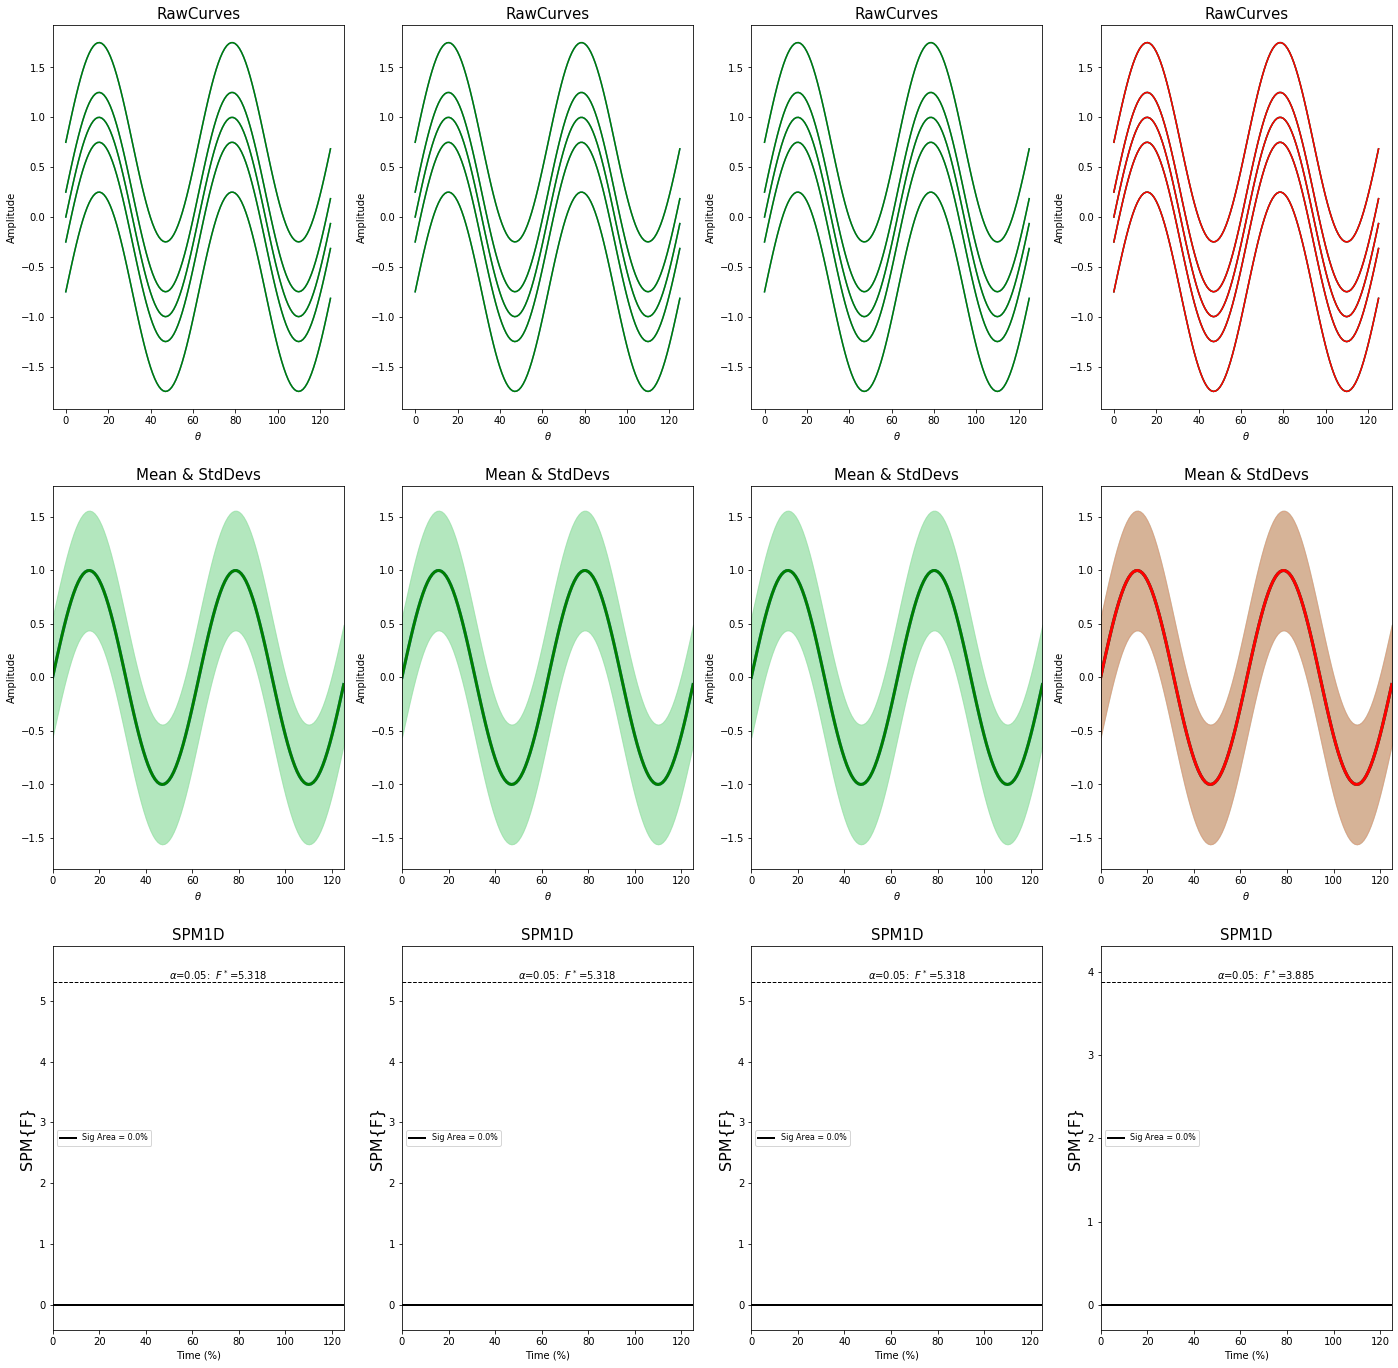

In [36]:
#########################################################################################
#                                       3 - PLOTS
#########################################################################################          
            
fig, axs = plt.subplots(nrows=3,ncols=len(Test_Set_Dict), figsize=(24, 24))    
      
for i in range(3):
    for j, jv in enumerate(Test_Set_Dict):   #j == index, jv == value

        
        # Row 1 - Raw Data Plot
        if i==0:
            axs[i,j].set_title('{}'.format(Titles[0]),fontsize=15)
            axs[i,j].set_xlabel(r'$\theta$', fontsize=10)
            axs[i,j].set_ylabel('Amplitude', fontsize=10)

            for k in set(Test_Set_Dict[jv]['A']):
                axs[i,j].plot(Test_Set_Dict[jv]['Y'][Test_Set_Dict[jv]['A']==k].T, Colours[0][k])
                
        # Row 2 - Mean and StdDev 
        elif i==1:
            axs[i,j].set_title('{}'.format(Titles[1]),fontsize=15)
            axs[i,j].set_xlabel(r'$\theta$', fontsize=10)
            axs[i,j].set_ylabel('Amplitude', fontsize=10)

            for k in set(Test_Set_Dict[jv]['A']):
                spm1d.plot.plot_mean_sd(Test_Set_Dict[jv]['Y'][Test_Set_Dict[jv]['A']==k], ax=axs[i,j], facecolor=Colours[1][k], 
                                        linecolor=Colours[0][k], edgecolor=Colours[1][k])

        # Row 3 - SPM1D
        elif i==2:
            axs[i,j].set_title('{}'.format(Titles[2]),fontsize=15)
            axs[i,j].set_xlabel('Time (%)', fontsize=10)
            axs[i,j].set_ylabel('SPM {F}', fontsize=10)
            
            Test_Set_Dict[jv]['Fi'].plot(ax=axs[i,j], color='k', 
                                        label='Sig Area = {0:.1f}%'.format(Test_Set_Dict[jv]['Fi_Sig_Area']))
            Test_Set_Dict[jv]['Fi'].plot_threshold_label(ax=axs[i,j],color='k',ha='left')
            axs[i,j].legend(fontsize=8, loc='center left')
            


    
